In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2

!pip install grad-cam
from pytorch_grad_cam import GradCAM, ScoreCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# ==========================================
# 1. 모델 구조 정의
# ==========================================
def build_efficientnet_b1(num_classes):
    # 가중치는 체크포인트에서 가져올 거라 weights=None으로 설정
    model = models.efficientnet_b1(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

class EfficientNetWithDropout(nn.Module):
    def __init__(self, model, num_classes, dropout_rate=0.5):
        super(EfficientNetWithDropout, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(model.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.dropout(x)
        return self.classifier(x)


In [4]:
# ==========================================
# 2. 체크포인트 로드 함수
# ==========================================
def load_checkpoint_model(ckpt_path, device):
    print(f"📂 Loading checkpoint from: {ckpt_path}")

    checkpoint = torch.load(ckpt_path, map_location=device)

    config = checkpoint.get("config", {})
    num_classes = config.get("num_classes", 27)
    print(f"ℹ️ Detected num_classes: {num_classes}")

    # 모델 틀 생성
    base_model = models.efficientnet_b1(weights=None)
    model = EfficientNetWithDropout(base_model, num_classes=num_classes)

    model.load_state_dict(checkpoint["model_state_dict"], strict=False)

    model.to(device)
    model.eval()
    return model


In [5]:
# ==========================================
# 3. CAM 별로 이름 넣기
# ==========================================
def put_text(img, text):
    # 이미지 상단에 검은 띠를 조금 추가하고 글씨 쓰기
    h, w, c = img.shape
    # 상단 여백 추가 (30px)
    new_img = np.zeros((h + 30, w, c), dtype=np.uint8)
    new_img[30:, :] = img

    # 텍스트 넣기 (White text)
    cv2.putText(new_img, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return new_img

In [6]:
# ==========================================
# 4. 전체 데이터셋 3종 CAM 저장 함수
# ==========================================
def save_all_cams_for_dataset(model, source_root, save_root, device):
    # 전처리
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Target Layer (마지막 Conv)
    target_layers = [model.features[0][-1]]

    cam_dict = {
        "Grad-CAM": GradCAM(model=model, target_layers=target_layers),
        "Score-CAM": ScoreCAM(model=model, target_layers=target_layers),
        "Layer-CAM": LayerCAM(model=model, target_layers=target_layers)
    }

    if not os.path.exists(source_root):
        print(f"Error: 원본 경로가 없습니다 -> {source_root}")
        return

    classes = sorted(os.listdir(source_root))
    print(f"총 {len(classes)}개 클래스에 대해 3종 CAM 생성을 시작합니다...")

    count = 0

    for cls_name in classes:
        src_class_dir = os.path.join(source_root, cls_name)
        save_class_dir = os.path.join(save_root, cls_name)

        if not os.path.isdir(src_class_dir):
            continue

        os.makedirs(save_class_dir, exist_ok=True)

        img_files = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        img_files = img_files[:10]

        print(f"  Processing folder: {cls_name} ({len(img_files)} images)...")

        for img_name in img_files:
            src_img_path = os.path.join(src_class_dir, img_name)
            save_img_path = os.path.join(save_class_dir, img_name)

            try:
                pil_img = Image.open(src_img_path).convert("RGB")
                pil_img_resized = pil_img.resize((224, 224))
                np_img = np.float32(pil_img_resized) / 255.0

                input_tensor = transform(pil_img).unsqueeze(0).to(device)

                orig_uint8 = (np_img * 255).astype(np.uint8)
                orig_bgr = cv2.cvtColor(orig_uint8, cv2.COLOR_RGB2BGR)

                results = [put_text(orig_bgr, "Original")]

                for cam_name, cam_obj in cam_dict.items():
                    grayscale_cam = cam_obj(input_tensor=input_tensor, targets=None)
                    grayscale_cam = grayscale_cam[0, :]

                    cam_overlay = show_cam_on_image(np_img, grayscale_cam, use_rgb=True)
                    cam_overlay_bgr = cv2.cvtColor(cam_overlay, cv2.COLOR_RGB2BGR)
                    results.append(put_text(cam_overlay_bgr, cam_name))

                final_image = np.hstack(results)
                cv2.imwrite(save_img_path, final_image)

                count += 1

            except Exception as e:
                print(f"⚠️ Error: {img_name} - {e}")

    print(f"\n완료! 총 {count}장 처리됨.")
    print(f"저장 경로: {save_root}")

In [7]:
# ==========================================
# [데모용] single image 만 출력하는 코드
# ==========================================
def run_demo_single_image(model, img_path, save_dir, device):
    # 1. 이미지 전처리
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. 이미지 로드
    if not os.path.exists(img_path):
        print(f"이미지 경로 오류: {img_path}")
        return

    print(f"이미지 처리 중: {os.path.basename(img_path)}")
    pil_img = Image.open(img_path).convert("RGB")
    pil_img_resized = pil_img.resize((224, 224))
    np_img = np.float32(pil_img_resized) / 255.0

    input_tensor = transform(pil_img).unsqueeze(0).to(device)

    # 3. CAM 준비
    target_layers = [model.features[0][-1]]
    cam_dict = {
        "Grad-CAM": GradCAM(model=model, target_layers=target_layers),
        "Score-CAM": ScoreCAM(model=model, target_layers=target_layers),
        "Layer-CAM": LayerCAM(model=model, target_layers=target_layers)
    }

    # 4. 결과 생성 (원본 + 3종 CAM)
    orig_uint8 = (np_img * 255).astype(np.uint8)
    orig_bgr = cv2.cvtColor(orig_uint8, cv2.COLOR_RGB2BGR)
    results = [put_text(orig_bgr, "Original")]

    for cam_name, cam_obj in cam_dict.items():
        # CAM 생성
        grayscale_cam = cam_obj(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]

        # Overlay
        cam_overlay = show_cam_on_image(np_img, grayscale_cam, use_rgb=True)
        cam_overlay_bgr = cv2.cvtColor(cam_overlay, cv2.COLOR_RGB2BGR)
        results.append(put_text(cam_overlay_bgr, cam_name))

    # 5. 이어 붙이기
    final_image = np.hstack(results)

    # 6. 저장
    os.makedirs(save_dir, exist_ok=True)
    file_name = os.path.basename(img_path)
    save_path = os.path.join(save_dir, f"Demo_{file_name}")

    cv2.imwrite(save_path, final_image)
    print(f"저장 완료: {save_path}")

    plt.figure(figsize=(20, 6))
    final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    plt.imshow(final_image_rgb)
    plt.axis('off')
    plt.title(f"Demo Result: {file_name}")
    plt.show()

📂 Loading checkpoint from: ./checkpoints/village_model_best.pt
ℹ️ Detected num_classes: 15
이미지 처리 중: Potato_Early_blight.JPG


100%|██████████| 80/80 [02:44<00:00,  2.06s/it]


저장 완료: ./results/PlantVillage-Result/Demo_Potato_Early_blight.JPG


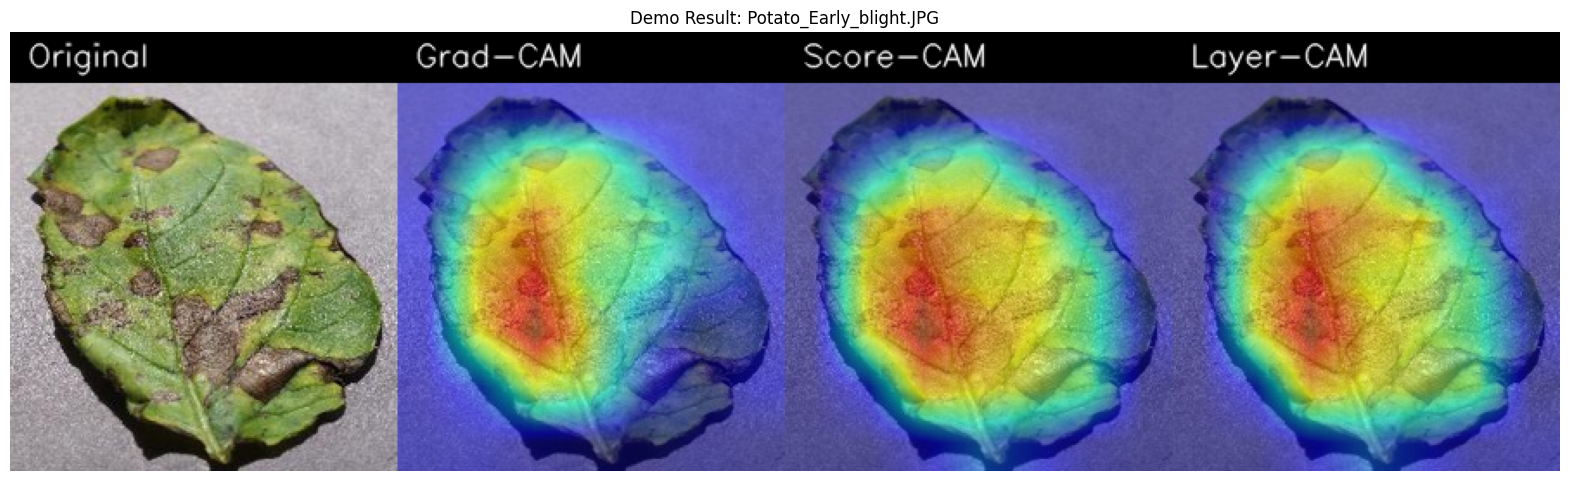

In [8]:
# ==========================================
# [데모용] 경로 확인 후 실행 - plantvillage
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. 경로 설정
ckpt_path = "./checkpoints/village_model_best.pt"
target_img_path = "./samples/Potato_Early_blight.JPG"
save_result_root = "./results/PlantVillage-Result"

# 2. 실행
if os.path.exists(ckpt_path):
    # 모델 로드
    model = load_checkpoint_model(ckpt_path, device)
    run_demo_single_image(model, target_img_path, save_result_root, device)
else:
    print(f"체크포인트 파일을 찾을 수 없습니다: {ckpt_path}")

📂 Loading checkpoint from: ./checkpoints/doc_model_best.pt
ℹ️ Detected num_classes: 27
이미지 처리 중: Tomato_leaf_late_blight.jpg


100%|██████████| 80/80 [02:38<00:00,  1.98s/it]


저장 완료: ./results/PlantDoc-Result/Demo_Tomato_leaf_late_blight.jpg


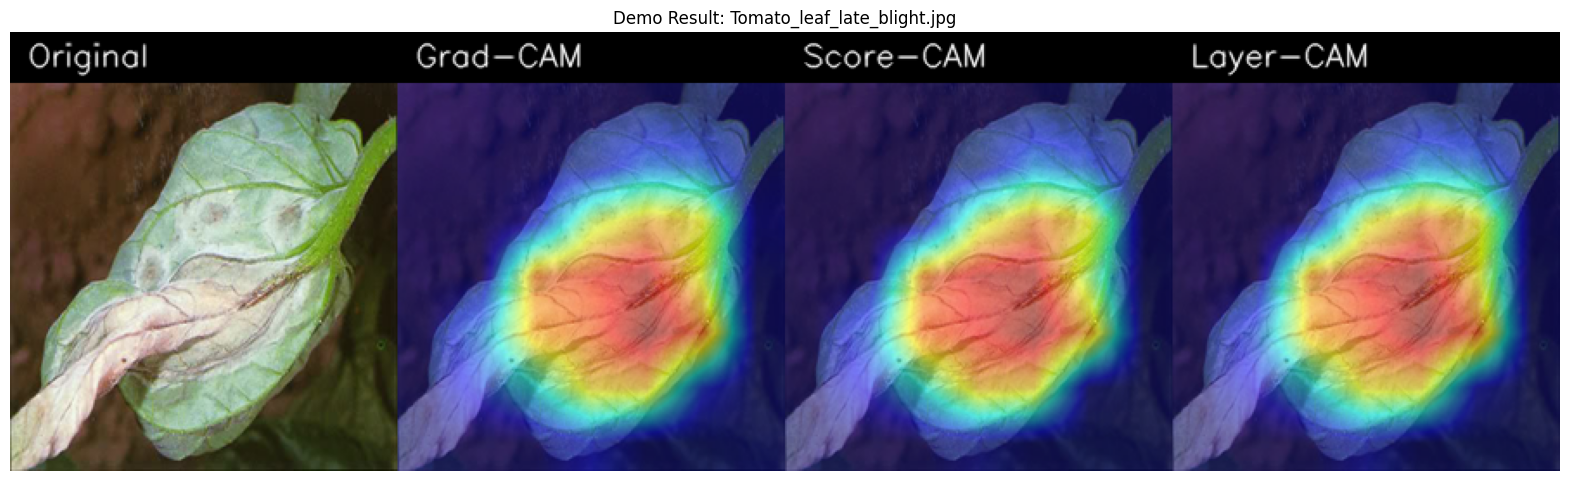

In [10]:
# ==========================================
# [데모용] 경로 확인 후 실행 - plantdoc
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. 경로 설정
ckpt_path = "./checkpoints/doc_model_best.pt"
target_img_path = "./samples/Tomato_leaf_late_blight.jpg"
save_result_root = "./results/PlantDoc-Result"

# 2. 실행
if os.path.exists(ckpt_path):
    # 모델 로드
    model = load_checkpoint_model(ckpt_path, device)
    run_demo_single_image(model, target_img_path, save_result_root, device)
else:
    print(f"체크포인트 파일을 찾을 수 없습니다: {ckpt_path}")